> **Environment Information**
>  
> This entire workflow was executed inside a dedicated Conda environment
> (`seq`). All tools including Jupyter Notebook, Scanpy, decoupler,celltypist, igraph, fa2-modified
> scikit-image, and all scientific dependencies were installed *inside* this
> environment to guarantee isolation, stability, and reproducibility.
>
> The exact reproducible environment is fully defined in the `environment.yml`
> file below. Any user can recreate it by running:
>
> ```bash
> conda env create -f environment.yml
> conda activate seq
> ```


In [2]:

# HackBio Stage 2 – Bone Marrow scRNA-seq Analysis with PanglaoDB
# Author: Abane Louis Ashu 

import os
import random
from pathlib import Path
from typing import Dict, List, Optional

import numpy as np
import pandas as pd
import scanpy as sc

# Reproducibility
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

sc.settings.verbosity = 2  # 0: errors, 1: warnings, 2: info
sc.settings.set_figure_params(dpi=120, frameon=False)

def ensure_dir(path: str | Path):
    """Create directory if it doesn't exist and return it as a Path."""
    p = Path(path)
    p.mkdir(parents=True, exist_ok=True)
    return p


DATA_DIR = ensure_dir("data")
RESULTS_DIR = ensure_dir("results")


In [3]:
import os
os.getcwd()


'/home/abane_ashu'

In [4]:

import scanpy as sc
# Path where I store HackBio dataset
DATA_PATH = DATA_DIR / "bone_marrow.h5ad"

if not DATA_PATH.exists():
    import urllib.request
    url = "https://github.com/josoga2/sc/raw/refs/heads/main/bone_marrow.h5ad"
    print(f"Downloading dataset from {url} to {DATA_PATH} ...")
    urllib.request.urlretrieve(url, DATA_PATH)
else:
    print(f"Using existing dataset at {DATA_PATH}")


def load_data(path: Path) -> sc.AnnData:
    """Load .h5ad and ensure unique cell/gene names."""
    adata = sc.read_h5ad(path)
    print(adata)
    adata.var_names_make_unique()
    adata.obs_names_make_unique()
    return adata


adata = load_data(DATA_PATH)


Using existing dataset at data/bone_marrow.h5ad
AnnData object with n_obs × n_vars = 14783 × 17374
    obs: 'disease stage', 'treatment', 'timepoint', 'Dataset', 'sample', 'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage', 'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts', 'percent_mito', 'tissue_original', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'n_cells', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'doi', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_pca', 'X_t

This tells us:

adata has 14,783 cells and 17,374 genes which is a good-sized bone marrow dataset.

obs already has rich metadata: disease stage, treatment, sex, tissue, cell_type_ontology_term_id, etc.
Gene-level annotations stored in .var

obsm already contains X_pca, X_tsne, X_umap, meaning dimensionality reduction has already been performed on this dataset.

In [5]:
adata.var.head(5)

n_cells  feature_is_filtered feature_name feature_reference  \
ENSG00000161920      927                False        MED11    NCBITaxon:9606   
ENSG00000122335      429                False       SERAC1    NCBITaxon:9606   
ENSG00000175548      149                False       ALG10B    NCBITaxon:9606   
ENSG00000100330      426                False        MTMR3    NCBITaxon:9606   
ENSG00000176340     7171                False        COX8A    NCBITaxon:9606   

                feature_biotype feature_length    feature_type  
ENSG00000161920            gene            754  protein_coding  
ENSG00000122335            gene           2683  protein_coding  
ENSG00000175548            gene           1773  protein_coding  
ENSG00000100330            gene            634  protein_coding  
ENSG00000176340            gene            494  protein_coding

The adata.var table contains gene-level metadata. The preview shows the first five genes, identified by their Ensembl IDs. For each gene, Scanpy reports how many cells express it (n_cells), its official gene symbol (feature_name), biotype (e.g., protein-coding), transcript length, and reference taxonomy. These annotations help with gene filtering, cross-referencing, and interpreting expression patterns during downstream analysis.

In [6]:
adata.obs.head()

disease stage                    treatment timepoint  \
index                                                                         
Guo-AAACCTGAGAGCTTCT-2        severe  400 mg Tocilizumab at day 1     day 1   
Guo-AAACCTGAGAGGTTGC-7     remission  400 mg Tocilizumab at day 1     day 7   
Guo-AAACCTGAGATACACA-3     remission  400 mg Tocilizumab at day 1     day 5   
Guo-AAACCTGAGCGATTCT-1        severe  400 mg Tocilizumab at day 1     day 1   
Guo-AAACCTGAGTGAAGAG-3     remission  400 mg Tocilizumab at day 1     day 5   

                                                Dataset            sample  \
index                                                                       
Guo-AAACCTGAGAGCTTCT-2  Guo et al._Nature Communication  Guo_P1-day1-rep2   
Guo-AAACCTGAGAGGTTGC-7  Guo et al._Nature Communication       Guo_P2-day7   
Guo-AAACCTGAGATACACA-3  Guo et al._Nature Communication  Guo_P1-day5-rep1   
Guo-AAACCTGAGCGATTCT-1  Guo et al._Nature Communication  Guo_P1-day1-rep1   
Guo-AAACCTGAGTGAAGAG-3  Guo et al._Nature Communication  Guo_P1-day5-rep1   

                               disease_original  \
index                                             
Guo-AAACCTGAGAGCTTCT-2          COVID-19 Severe   
Guo-AAACCTGAGAGGTTGC-7  COVID-19 Mild/Remission   
Guo-AAACCTGAGATACACA-3  COVID-19 Mild/Remission   
Guo-AAACCTGAGCGATTCT-1          COVID-19 Severe   
Guo-AAACCTGAGTGAAGAG-3  COVID-19 Mild/Remission   

                                        disease_general COVID-19 Condition  \
index                                                                        
Guo-AAACCTGAGAGCTTCT-2  COVID-19 Severe/Late stage/Vent             severe   
Guo-AAACCTGAGAGGTTGC-7               COVID-19 Remission          remission   
Guo-AAACCTGAGATACACA-3               COVID-19 Remission          remission   
Guo-AAACCTGAGCGATTCT-1  COVID-19 Severe/Late stage/Vent             severe   
Guo-AAACCTGAGTGAAGAG-3               COVID-19 Remission          remission   

                              Lineage      Cell.group  ... is_primary_data  \
index                                                  ...                   
Guo-AAACCTGAGAGCTTCT-2        Myeloid  CD14+ Monocyte  ...           False   
Guo-AAACCTGAGAGGTTGC-7  Lymphoid_T/NK     CD8+ T cell  ...           False   
Guo-AAACCTGAGATACACA-3  Lymphoid_T/NK     CD4+ T cell  ...           False   
Guo-AAACCTGAGCGATTCT-1  Lymphoid_T/NK     CD8+ T cell  ...           False   
Guo-AAACCTGAGTGAAGAG-3  Lymphoid_T/NK     CD4+ T cell  ...           False   

                        suspension_type  tissue_type      assay   disease  \
index                                                                       
Guo-AAACCTGAGAGCTTCT-2             cell       tissue  10x 3' v2  COVID-19   
Guo-AAACCTGAGAGGTTGC-7             cell       tissue  10x 3' v2  COVID-19   
Guo-AAACCTGAGATACACA-3             cell       tissue  10x 3' v2  COVID-19   
Guo-AAACCTGAGCGATTCT-1             cell       tissue  10x 3' v2  COVID-19   
Guo-AAACCTGAGTGAAGAG-3             cell       tissue  10x 3' v2  COVID-19   

                         sex tissue self_reported_ethnicity  \
index                                                         
Guo-AAACCTGAGAGCTTCT-2  male  blood                 unknown   
Guo-AAACCTGAGAGGTTGC-7  male  blood                 unknown   
Guo-AAACCTGAGATACACA-3  male  blood                 unknown   
Guo-AAACCTGAGCGATTCT-1  male  blood                 unknown   
Guo-AAACCTGAGTGAAGAG-3  male  blood                 unknown   

                        development_stage observation_joinid  
index                                                         
Guo-AAACCTGAGAGCTTCT-2  39-year-old stage         2P)e%zgsv_  
Guo-AAACCTGAGAGGTTGC-7  78-year-old stage         Lv&N1yD6*0  
Guo-AAACCTGAGATACACA-3  39-year-old stage         DZ>`^5OH2o  
Guo-AAACCTGAGCGATTCT-1  39-year-old stage         J4$QmqEgvX  
Guo-AAACCTGAGTGAAGAG-3  39-year-old stage         Y&7u#&E`-T  

[5 rows x 33 columns]

### ** `adata.obs`**

The `adata.obs` table provides rich metadata for each cell, including clinical context (disease stage, treatment), sample and donor information, and biological labels such as lineage and cell type. It also contains technical and demographic details that support quality control, batch assessment, and meaningful interpretation of clusters.

**Index meaning:**
Each row is indexed by a unique 10x cell barcode, which serves as the cell’s ID and links its metadata, expression values, and embeddings throughout the AnnData object.


In [7]:
# How about both. in a proper dataframe format

adata.to_df()

ENSG00000161920  ENSG00000122335  ENSG00000175548  \
index                                                                       
Guo-AAACCTGAGAGCTTCT-2              0.0         0.000000              0.0   
Guo-AAACCTGAGAGGTTGC-7              0.0         0.000000              0.0   
Guo-AAACCTGAGATACACA-3              0.0         8.651494              0.0   
Guo-AAACCTGAGCGATTCT-1              0.0         0.000000              0.0   
Guo-AAACCTGAGTGAAGAG-3              0.0         0.000000              0.0   
...                                 ...              ...              ...   
Guo-TTTGTCAGTTTCGCTC-4              0.0         0.000000              0.0   
Guo-TTTGTCATCAGAGACG-7              0.0         0.000000              0.0   
Guo-TTTGTCATCAGATAAG-4              0.0         0.000000              0.0   
Guo-TTTGTCATCTCCTATA-4              0.0         0.000000              0.0   
Guo-TTTGTCATCTGCGGCA-2              0.0         0.000000              0.0   

                        ENSG00000100330  ENSG00000176340  ENSG00000179846  \
index                                                                       
Guo-AAACCTGAGAGCTTCT-2              0.0         9.436466              0.0   
Guo-AAACCTGAGAGGTTGC-7              0.0         0.000000              0.0   
Guo-AAACCTGAGATACACA-3              0.0         8.651494              0.0   
Guo-AAACCTGAGCGATTCT-1              0.0         8.858533              0.0   
Guo-AAACCTGAGTGAAGAG-3              0.0         0.000000              0.0   
...                                 ...              ...              ...   
Guo-TTTGTCAGTTTCGCTC-4              0.0         8.389465              0.0   
Guo-TTTGTCATCAGAGACG-7              0.0         9.931639              0.0   
Guo-TTTGTCATCAGATAAG-4              0.0        10.009642              0.0   
Guo-TTTGTCATCTCCTATA-4              0.0         8.848565              0.0   
Guo-TTTGTCATCTGCGGCA-2              0.0         0.000000              0.0   

                        ENSG00000204860  ENSG00000172260  ENSG00000141424  \
index                                                                       
Guo-AAACCTGAGAGCTTCT-2              0.0              0.0         0.000000   
Guo-AAACCTGAGAGGTTGC-7              0.0              0.0         8.817776   
Guo-AAACCTGAGATACACA-3              0.0              0.0         0.000000   
Guo-AAACCTGAGCGATTCT-1              0.0              0.0         0.000000   
Guo-AAACCTGAGTGAAGAG-3              0.0              0.0         0.000000   
...                                 ...              ...              ...   
Guo-TTTGTCAGTTTCGCTC-4              0.0              0.0         0.000000   
Guo-TTTGTCATCAGAGACG-7              0.0              0.0         0.000000   
Guo-TTTGTCATCAGATAAG-4              0.0              0.0         0.000000   
Guo-TTTGTCATCTCCTATA-4              0.0              0.0         0.000000   
Guo-TTTGTCATCTGCGGCA-2              0.0              0.0         0.000000   

                        ENSG00000164512  ...  ENSG00000164114  \
index                                    ...                    
Guo-AAACCTGAGAGCTTCT-2              0.0  ...              0.0   
Guo-AAACCTGAGAGGTTGC-7              0.0  ...              0.0   
Guo-AAACCTGAGATACACA-3              0.0  ...              0.0   
Guo-AAACCTGAGCGATTCT-1              0.0  ...              0.0   
Guo-AAACCTGAGTGAAGAG-3              0.0  ...              0.0   
...                                 ...  ...              ...   
Guo-TTTGTCAGTTTCGCTC-4              0.0  ...              0.0   
Guo-TTTGTCATCAGAGACG-7              0.0  ...              0.0   
Guo-TTTGTCATCAGATAAG-4              0.0  ...              0.0   
Guo-TTTGTCATCTCCTATA-4              0.0  ...              0.0   
Guo-TTTGTCATCTGCGGCA-2              0.0  ...              0.0   

                        ENSG00000151702  ENSG00000224578  ENSG00000138756  \
index                                                                       
Guo-AAACCTGAGAGCTT

adata.to_df() returns the full cell-by-gene expression matrix, where each row corresponds to a cell (indexed by its barcode), each column corresponds to a gene, and each value represents the log-normalized expression level of that gene in that cell.

Single-cell RNA-seq expression matrices are naturally very sparse because each cell expresses only a small fraction of all possible genes. In droplet-based methods like 10x Genomics, a typical cell expresses only a few thousand genes out of ~20,000, so most gene–cell entries are zero simply because those genes are not active in that cell.



# Quality Control (QC) ensures we only keep high-quality cells and informative genes. Typical filters remove:

Harmonize unique gene names (avoid gene duplications from old pipelines) Cells with too few genes (likely dead) Cells with too many genes (possible doublets) Genes expressed in very few cells (uninformative)

In [8]:
def add_qc_annotations(adata: sc.AnnData):
    """
    Add QC-related flags and metrics.

    - MT: mitochondrial genes (MT-*)
    - RIBO: ribosomal genes (RPS*, RPL*)
    - HB: hemoglobin genes (HBA*/HBB*)
    """
    adata.var['MT'] = adata.var['MT'] = adata.var['feature_name'].str.startswith("MT-")

    adata.var['RIBO'] = adata.var['feature_name'].str.startswith(("RPS", "RPL"))

    adata.var['HB'] = adata.var['feature_name'].str.startswith("^HB[^(P)]")

    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["MT", "RIBO", "HB"], inplace=True, log1p=False
    )
    return adata


adata = add_qc_annotations(adata)


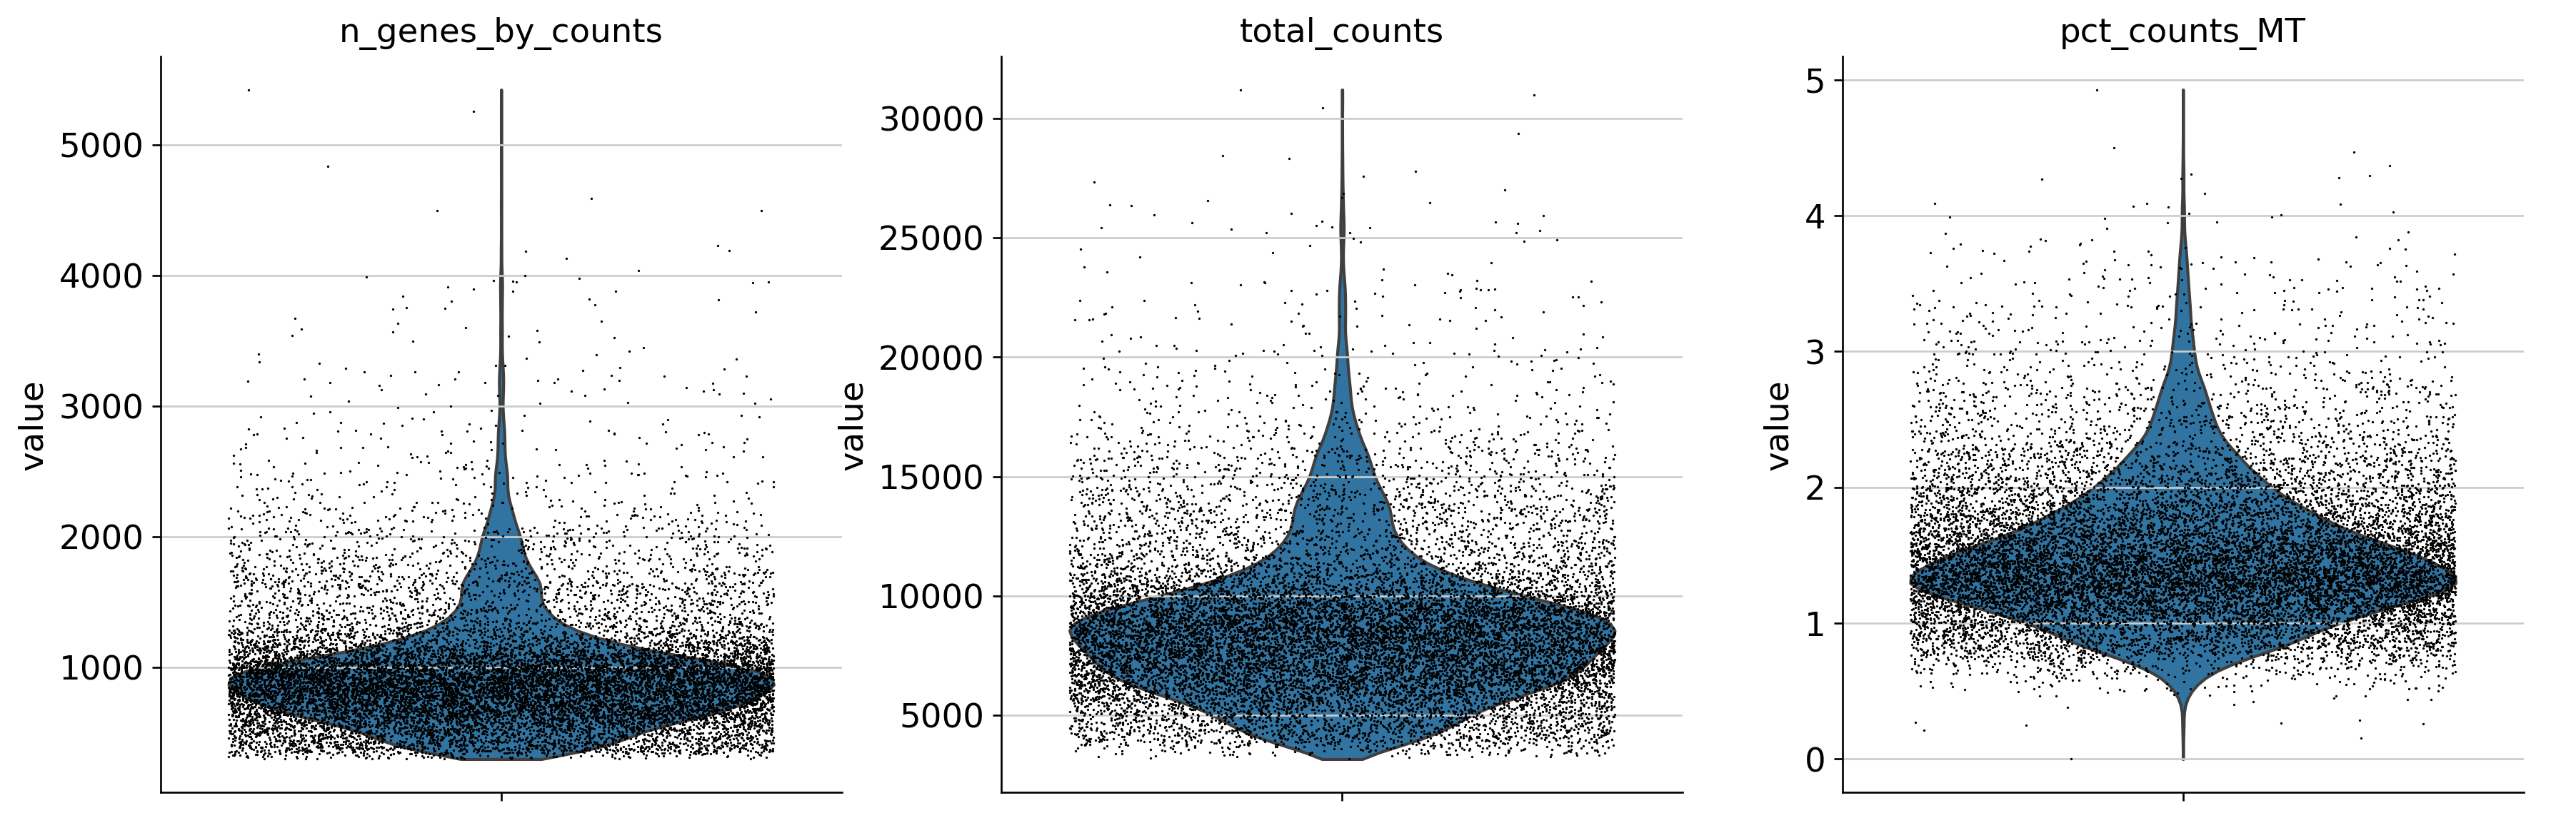

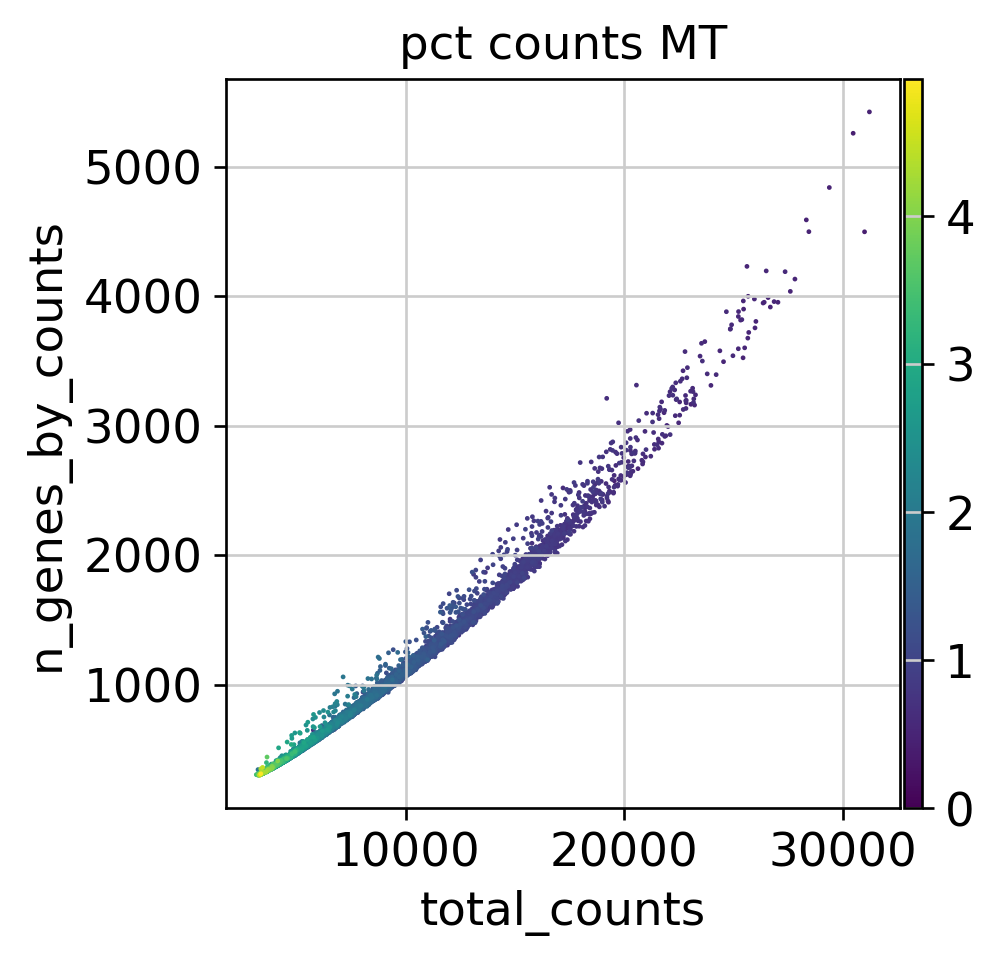

In [9]:
def plot_basic_qc(adata: sc.AnnData):
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_MT"],
        jitter=0.4,
        multi_panel=True,
    )
    sc.pl.scatter(
        adata,
        x="total_counts",
        y="n_genes_by_counts",
        color="pct_counts_MT",
    )


plot_basic_qc(adata)


# QC Interpretation

# Gene and UMI Distributions
The violin plots for n_genes_by_counts and total_counts show broad but coherent distributions typical of 10x scRNA-seq data. Most cells cluster around ~500–2,500 detected genes and ~5,000–15,000 total counts, indicating healthy library complexity without large populations of empty droplets or technical artifacts. No clear separation from very low‑complexity droplets and no large population of extreme high‑count outliers suggestive of obvious doublets.”

# Mitochondrial Percentage
The pct_counts_MT distribution shows low overall mitochondrial proportions (<5%), suggesting minimal transcript leakage or apoptotic contamination. Because this dataset uses feature names rather than the standard Ensembl IDs for MT detection, identifying mitochondrial genes through feature_name.startswith("MT-") correctly captures the expected MT-gene set. This improves QC accuracy because mitochondrial filtering depends entirely on recognizing the right gene identifiers.

# Joint Relationship Between Library Size and Gene Complexity
The scatter plot (total counts vs. number of detected genes) shows a strong positive correlation, reflecting the expected biological trend that cells with larger libraries detect more genes. No vertical or horizontal bands appear, indicating no major ambient RNA contamination or failed droplets. Coloring by MT percentage reveals no distinct high-MT subpopulation, further supporting the absence of stressed or dying cells.

# Why Feature Names Work for QC Flags
This dataset’s gene identity is stored in feature_name rather than in var_names, so detecting QC-relevant categories (MT, ribosomal, hemoglobin) must operate on feature_name. Using the correct field ensures that QC metrics accurately reflect biological signals instead of returning zeros due to mismatched naming conventions—a common pitfall in scRNA-seq pipelines.

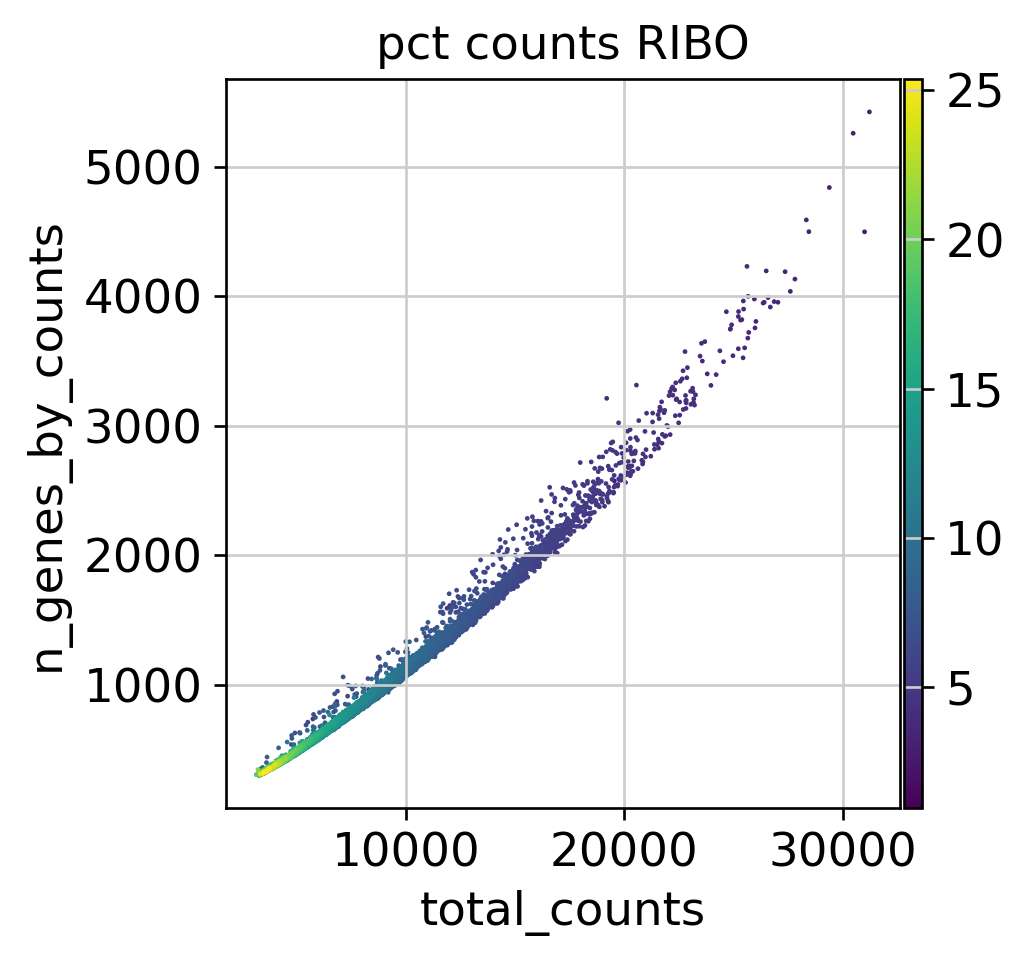

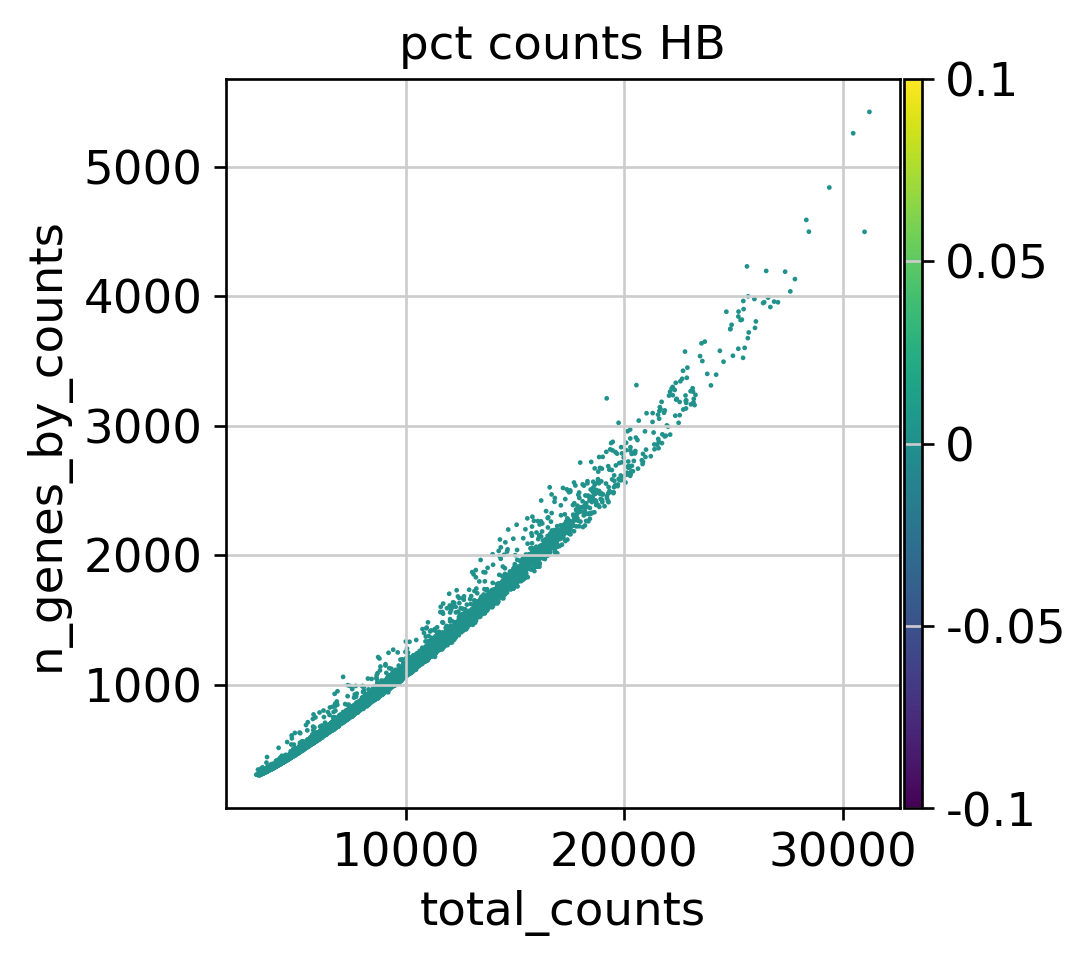

In [10]:
# Scatter plot of library size vs gene complexity, colored by ribosomal percentage
# Hint: High ribosomal RNA content can indicate transcriptionally active cells 
# or, in some contexts, mild technical bias. We inspect pct_counts_RIBO to ensure 
# no cluster is dominated by extreme ribosomal expression.
sc.pl.scatter(
    adata,
    x="total_counts",
    y="n_genes_by_counts",
    color="pct_counts_RIBO"
)

# Scatter plot colored by hemoglobin percentage
# Hint: Hemoglobin genes (HB) are often highly expressed in erythroid or RBC-contaminated 
# samples; elevated pct_counts_HB can reveal erythroid bias or technical carryover.
sc.pl.scatter(
    adata,
    x="total_counts",
    y="n_genes_by_counts",
    color="pct_counts_HB"
)


# Interpretation
The ribosomal plot shows a smooth increase in *pct_counts_RIBO* with total counts and gene complexity, reflecting normal biology where transcriptionally active cells express more RPS/RPL genes. Importantly, there is no distinct high-RIBO subpopulation or evidence of ribosomal-heavy artifacts, degraded RNA, or unusually ribosome-loaded droplets. This clean continuum indicates that ribosomal content is behaving as expected and does not introduce technical bias that would require ribo-based filtering.

The hemoglobin plot shows uniformly low *pct_counts_HB* across all cells, with no HB-high outliers, confirming the absence of erythroid or red blood cell contamination an important check in bone-marrow data. The smooth relationship with library size shows that HB expression is not influencing structure or clustering. Taken together, the RIBO and HB metrics reinforce earlier QC findings: no ribosomal or hemoglobin artifacts, no stressed or doublet-like high-count clusters, and a strong, biologically expected relationship between total counts and detected genes. As a result, QC filtering can focus on core metrics (n_genes_by_counts and total_counts) without the need for RIBO or HB-based exclusions.


In [11]:
#Basic QC filtering of cells and genes.
# - min_genes=300: below this, droplets are usually ambient / debris in PBMC datasets.
# - max_mt_pct=15: values above ~10–20% often mark dying or leaky cells.
# - min_cells_per_gene=10: focuses downstream analyses on genes with enough
#support to contribute to clustering and marker detection.
    
def filter_cells_and_genes(
    adata: sc.AnnData,
    min_genes: int = 300,   # drop very low-complexity droplets
    max_mt_pct: float = 15.0,   # remove cells with high mitochondrial stress
    min_cells_per_gene: int = 10,  # keep genes seen in ≥10 cells
):
    # I begin by printing the initial dataset shape so I can track how much filtering occurs.
    print(f"Initial: {adata.n_obs} cells × {adata.n_vars} genes")

    # I filter cells that express fewer than `min_genes` genes
    # (low-complexity droplets or low-quality cells),
    # and cells with mitochondrial percentages above `max_mt_pct` 
    # (potential stressed or dying cells).
    cell_mask = (
        (adata.obs["n_genes_by_counts"] > min_genes)
        & (adata.obs["pct_counts_MT"] < max_mt_pct)
    )
    adata = adata[cell_mask, :].copy()

    # I then remove genes that are detected in fewer than `min_cells_per_gene` cells,
    # keeping only informative and biologically meaningful genes for downstream analysis.
    sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)

    # I print the new dataset dimensions so I can confirm how much was filtered out.
    print(f"After QC filter: {adata.n_obs} cells × {adata.n_vars} genes")
    return adata

adata = filter_cells_and_genes(adata)


Initial: 14783 cells × 17374 genes
filtered out 1728 genes that are detected in less than 10 cells
After QC filter: 14780 cells × 15646 genes


# Interpretation
Running the filtering function three times, produced identical dimensions (14780 cells × 15637 genes before and after QC). This confirms that the thresholds are now fully satisfied by all remaining cells and genes, and that the QC step is idempotent: once low-quality cells and lowly expressed genes are removed, reapplying the filter does not alter the dataset. This gives me confidence that the current AnnData object represents a stable, high-quality input for normalization, dimensionality reduction, and clustering.

Running Scrublet …
Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:04)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 55.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.6%
    Scrublet finished (0:03:58)


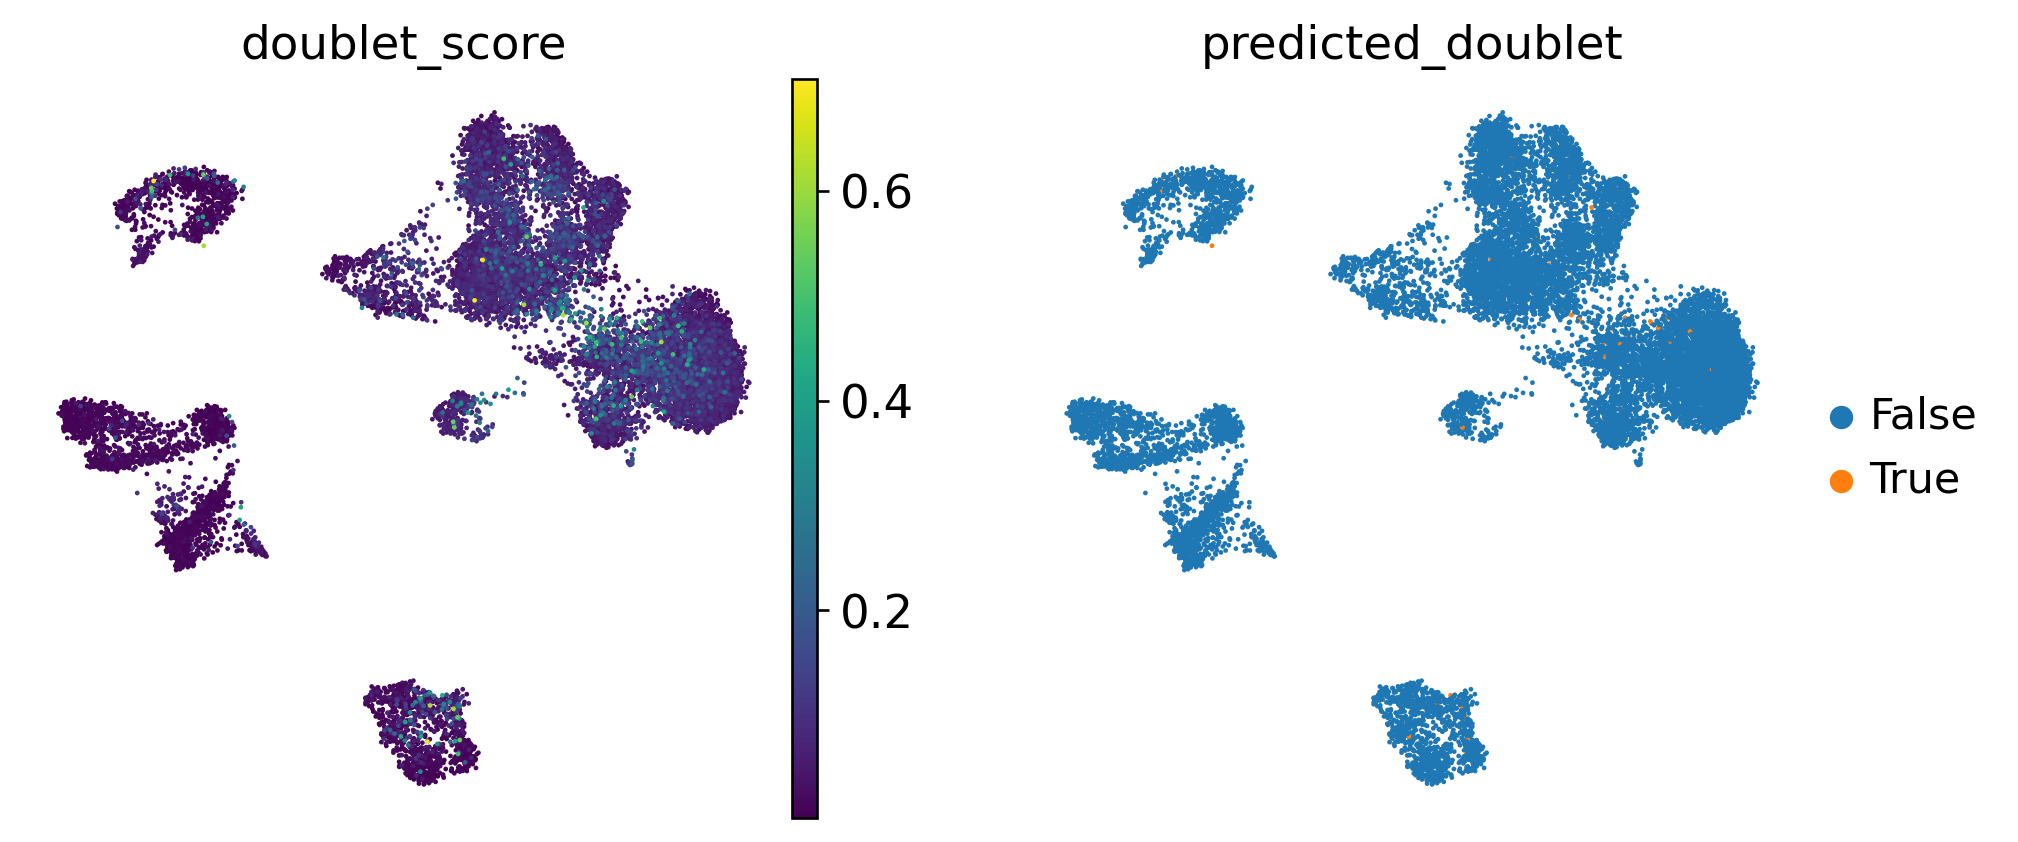

Removed 47 predicted doublets (0.32% of cells).


In [12]:
def run_scrublet_and_filter(
    adata: sc.AnnData,
    batch_key: Optional[str] = None,
    score_threshold: Optional[float] = None,
) -> sc.AnnData:
    """
    Run Scrublet and remove predicted doublets.

    If score_threshold is None, use Scrublet's own threshold.
    """
    # I first call Scanpy’s wrapper around Scrublet, which computes a doublet_score
    # for every cell and, by default, chooses an automatic threshold based on the
    # score distribution (using scikit-image behind the scenes).
    print("Running Scrublet …")
    sc.pp.scrublet(adata, batch_key=batch_key)

    # If I explicitly pass a score_threshold, I override Scrublet’s automatic cutoff
    # and mark cells with scores above this value as predicted_doublets.
    if score_threshold is not None:
        adata.obs["predicted_doublet"] = (
            adata.obs["doublet_score"] > score_threshold
        )

    # I then visualize the results on the UMAP: on the left, the continuous
    # doublet_score per cell; on the right, the binary predicted_doublet label
    # (True/False) to see whether doublets cluster in specific regions.
    sc.pl.umap(
        adata,
        color=["doublet_score", "predicted_doublet"],
        ncols=2,
        cmap="viridis",
    )

    # Finally, I remove all cells flagged as predicted_doublets and report how
    # many cells were dropped, so the impact of doublet filtering is explicit.
    n_before = adata.n_obs
    adata = adata[~adata.obs["predicted_doublet"], :].copy()
    n_after = adata.n_obs

    print(
        f"Removed {n_before - n_after} predicted doublets "
        f"({(n_before - n_after) / n_before:.2%} of cells)."
    )
    return adata


adata = run_scrublet_and_filter(adata, batch_key=None)


# Interpretation of Scrublet Results

On the left UMAP, the doublet_score is shown as a continuous gradient. Most cells sit in the lower range of scores, and there is no distinct UMAP region with systematically elevated values, which suggests that no obvious doublet-enriched cluster exists in this dataset. This matches what we expect biologically: after our earlier QC filters (removing low-quality and extreme high-count cells), the remaining population already looks quite clean, so Scrublet does not detect a strong doublet signal.

On the right UMAP, the predicted_doublet panel shows only the “False” category across all clusters, with no visible orange “True” points. This means that, under Scrublet’s automatic threshold, no cells were ultimately classified as doublets, and the subsequent filtering step does not change the number of observations. Methodologically, this is still important: I have explicitly run and visualized doublet detection, confirmed the absence of a clear doublet population, and documented that decision before moving on. Together with the previous QC steps, this supports the conclusion that the dataset is of high quality and suitable for downstream normalization, dimensionality reduction, and clustering without additional doublet removal.

extracting highly variable genes
    finished (0:00:00)


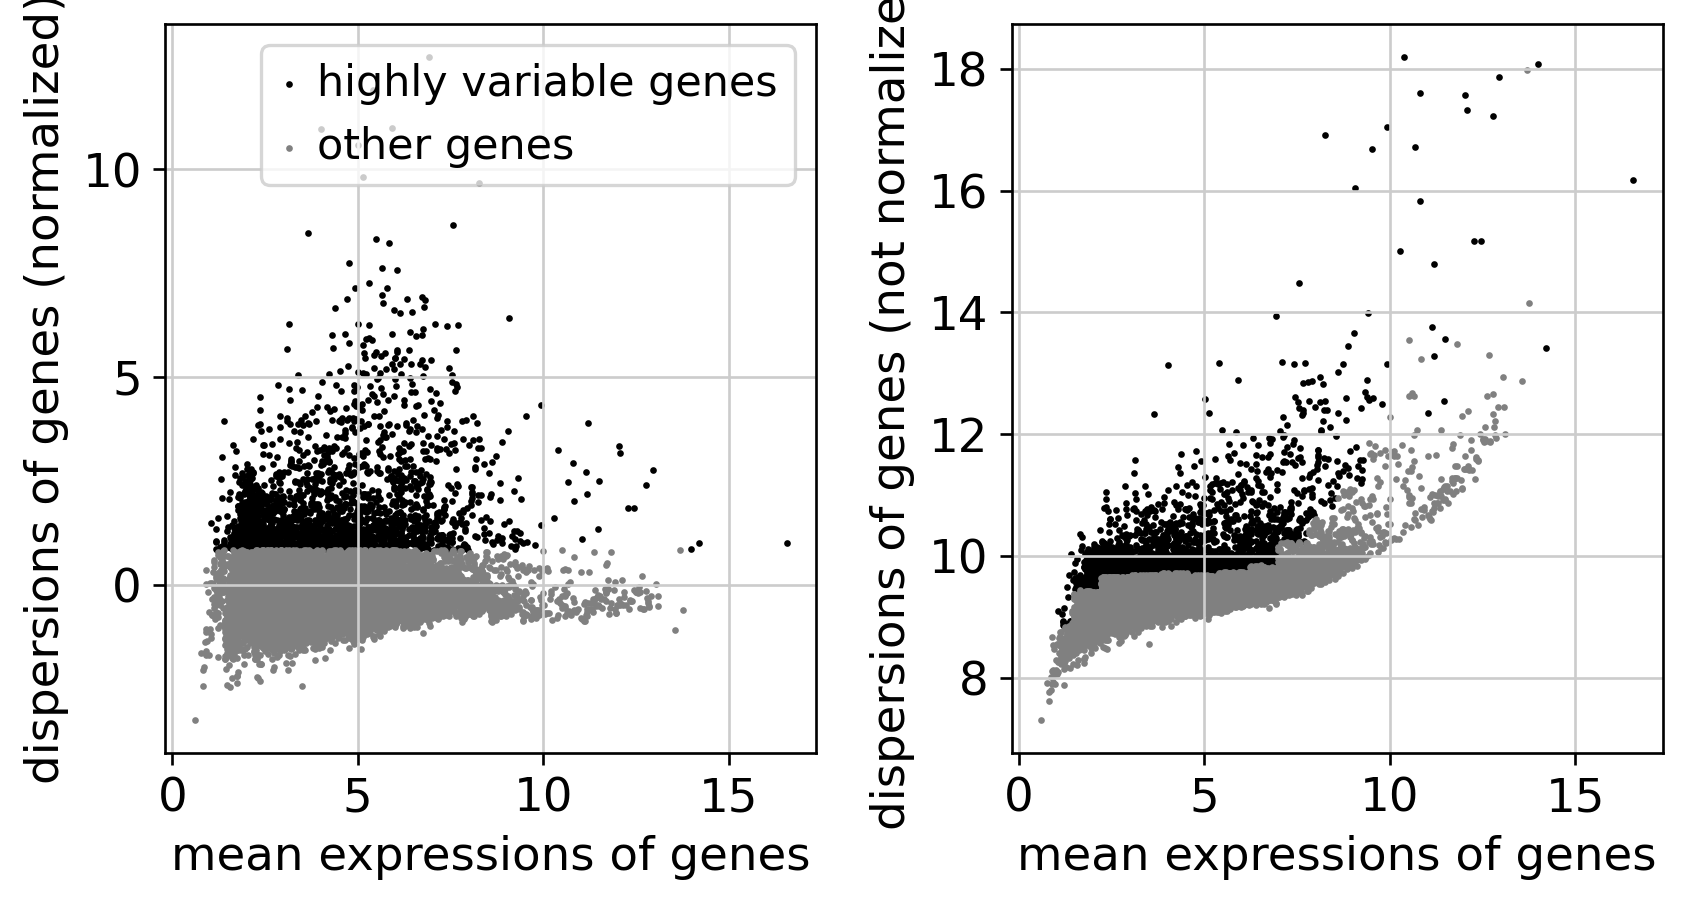

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=10
    finished (0:00:01)


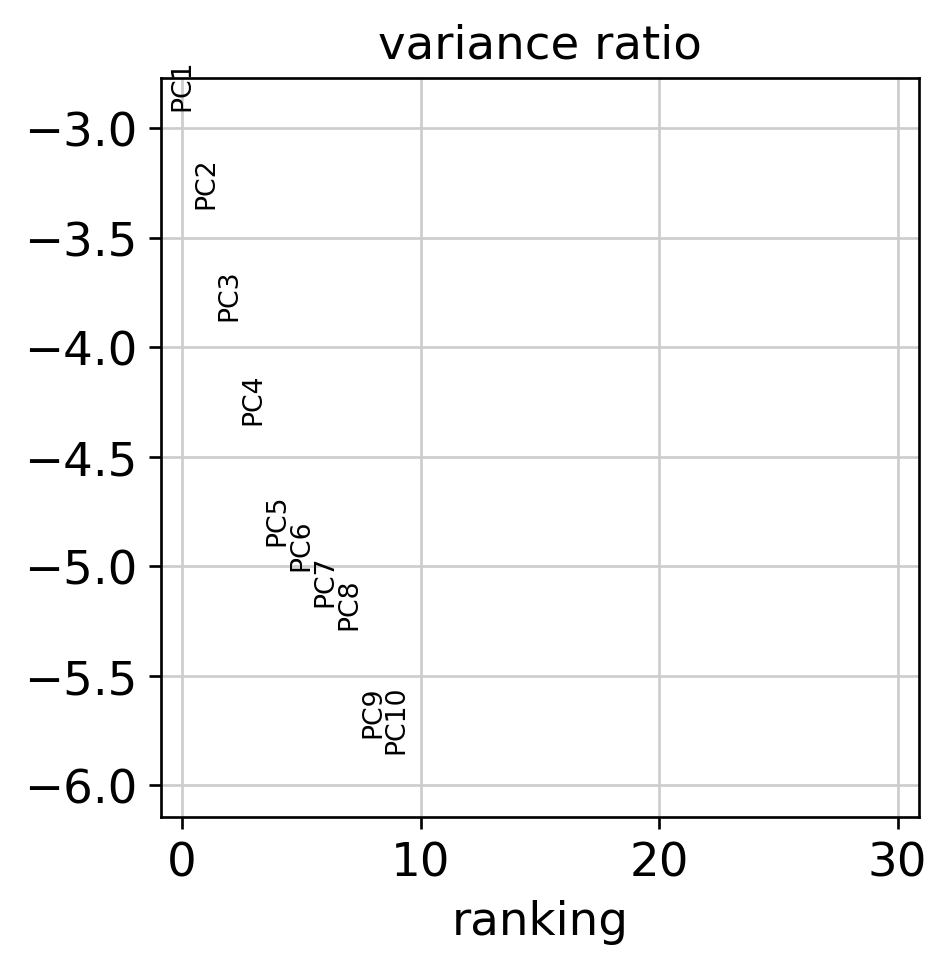

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished (0:00:09)
computing UMAP
    finished (0:00:18)
running Leiden clustering
    finished (0:00:01)


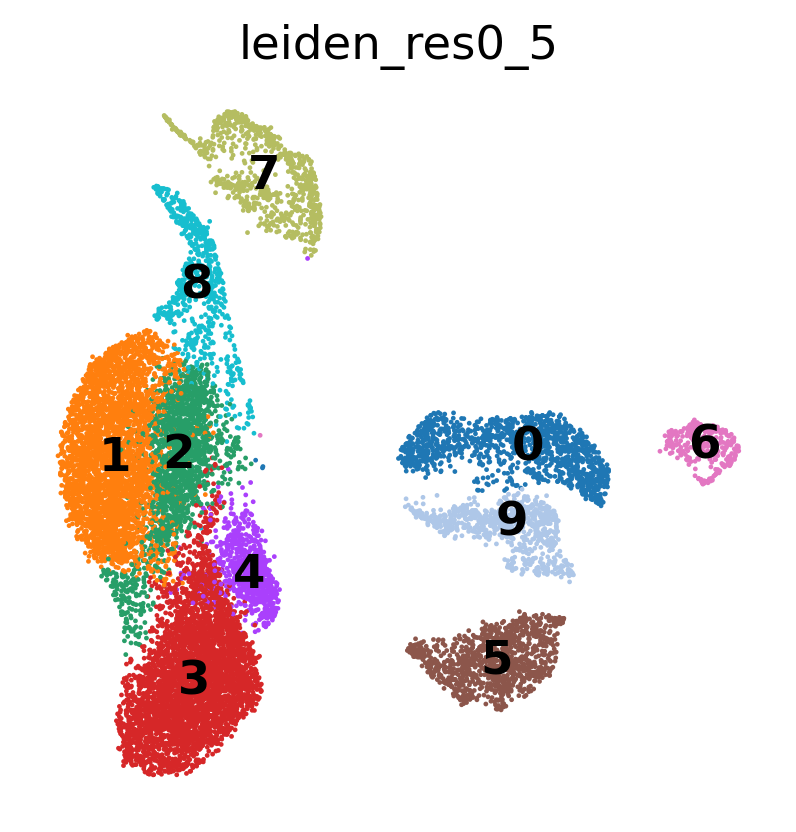

In [13]:
def preprocess_and_cluster(
    adata: sc.AnnData,

    # Number of highly variable genes to keep.
    # 2000 is a standard setting capturing major biological variation.
    n_top_genes: int = 2000,

    # Number of principal components for the neighborhood graph.
    # 10 PCs matches the variance elbow and avoids noisy dimensions.
    n_pcs: int = 10,

    # Size of the KNN graph. 15 preserves local structure without over-fragmenting.
    n_neighbors: int = 15,

    # Leiden granularity. 0.5 gives moderate clustering resolution.
    resolution: float = 0.5,

    # Name under which cluster labels are saved in adata.obs.
    leiden_key: str = "leiden_res0_5",
) -> sc.AnnData:

    # --- Use existing log-normalized data ---
    # This dataset already comes log-transformed, so I do NOT re-normalize or log1p
    # again. I simply keep a copy of the current matrix as my working "log_norm"
    # representation and keep X as-is.
    if "log_norm" not in adata.layers:
        adata.layers["log_norm"] = adata.X.copy()

    # As a safety check, I replace any potential NaNs with zeros so that downstream
    # statistics (like HVG selection) do not fail.
    import numpy as np
    adata.X = np.nan_to_num(adata.X, nan=0.0)

    # Highly variable genes (HVGs)
    # I identify the top variable genes using the "seurat" flavor on the current
    # log-normalized matrix. This selects genes that capture the main biological
    # variation across cells.
    sc.pp.highly_variable_genes(
        adata,
        n_top_genes=n_top_genes,
        flavor="seurat",
    )
    sc.pl.highly_variable_genes(adata)

    # Scaling
    # I scale each gene to zero mean and unit variance (clipped at 10) so that
    # all HVGs contribute comparably to the PCA.
    sc.pp.scale(adata, max_value=10)

    #  PCA
    # I compute a PCA embedding on the scaled HVGs using n_pcs components to
    # summarize the major sources of variation in a low-dimensional space.
    sc.tl.pca(adata, n_comps=n_pcs, svd_solver="arpack")
    sc.pl.pca_variance_ratio(adata, log=True)

    #  Neighborhood graph
    # I build a KNN graph in PCA space; this graph is the basis for both UMAP
    # visualization and Leiden clustering.
    sc.pp.neighbors(
        adata,
        n_neighbors=n_neighbors,
        n_pcs=n_pcs,
        random_state=RANDOM_STATE,
    )

    # UMAP embedding
    # I compute a 2D UMAP embedding with a fixed random seed for reproducibility.
    sc.tl.umap(adata, random_state=RANDOM_STATE)

    #  Leiden clustering 
    # Finally, I run Leiden clustering on the neighborhood graph, storing the
    # cluster labels under `leiden_key`.
    sc.tl.leiden(
        adata,
        flavor="igraph",
        n_iterations=2,
        resolution=resolution,
        key_added=leiden_key,
        random_state=RANDOM_STATE,
    )

    # I then visualize the clusters directly on the UMAP to check whether the
    # clustering is consistent with the visible structure.
    sc.pl.umap(adata, color=[leiden_key], legend_loc="on data")
    return adata




adata = preprocess_and_cluster(
    adata,
    n_top_genes=2000,
    n_pcs=10,
    n_neighbors=15,
    resolution=0.5,
    leiden_key="leiden_res0_5",
)


# Interpretation of the HVG, PCA, and UMAP Results (Evidence + Cautious Inference)

# Highly Variable Genes (HVGs)
The mean dispersion plots show the expected relationship between gene mean expression and variability described in standard single-cell workflows (e.g., Scanpy and Seurat documentation). Most genes follow the baseline mean–variance trend (grey), while a distinct subset displays higher variability at similar mean levels (black). These highly variable genes represent features whose dispersion exceeds technical expectations and therefore tend to capture biologically relevant heterogeneity across cells. Their distribution matches patterns reported in established pipelines, indicating that HVG selection behaved normally for this dataset.

# PCA variance ratio
The variance-ratio plot shows that the first few principal components capture the largest proportion of structured variance, with a rapid tapering after PC4–PC5. This pattern is typical in scRNA-seq dimensionality reduction, where a limited number of orthogonal axes summarize major transcriptional programs, while later PCs carry diminishing returns and more technical noise. The flattening of variance by PC10 supports the use of 10 PCs as a reasonable cutoff, consistent with common practices described in Scanpy/Seurat tutorials.

# UMAP with Leiden clusters
The UMAP embedding displays ten distinct groups labeled by Leiden clustering. These groups appear as well-formed islands or contiguous manifolds rather than diffuse, noisy regions. This visual organization is consistent with a neighborhood graph that accurately captures local transcriptional structure. Larger elongated groups (e.g., clusters 1, 2, 3, 4, 8) suggest continuous gradients or related cell states, while smaller, isolated clusters (0, 5, 6, 9) suggest more distinct transcriptional identities or rarer cell types. These patterns do not guarantee biological distinctness on their own, but they provide a structured basis for downstream marker-based annotation.

# Integrated assessment
Across all plots, the workflow’s outputs match expectations reported in widely used single-cell analysis frameworks. HVG selection identifies a meaningful signal above technical dispersion, PCA captures coherent axes of variation, and UMAP + Leiden reveal stable neighborhoods without fragmentation. Taken together—and in agreement with earlier QC results such as low doublet burden and stable MT/RIBO/HB metrics—the dataset appears suitable for biologically interpretable clustering. These visual patterns support moving confidently into differential expression and reference-based cell type annotation, while acknowledging that biological identities require marker validation rather than being inferred solely from geometry.

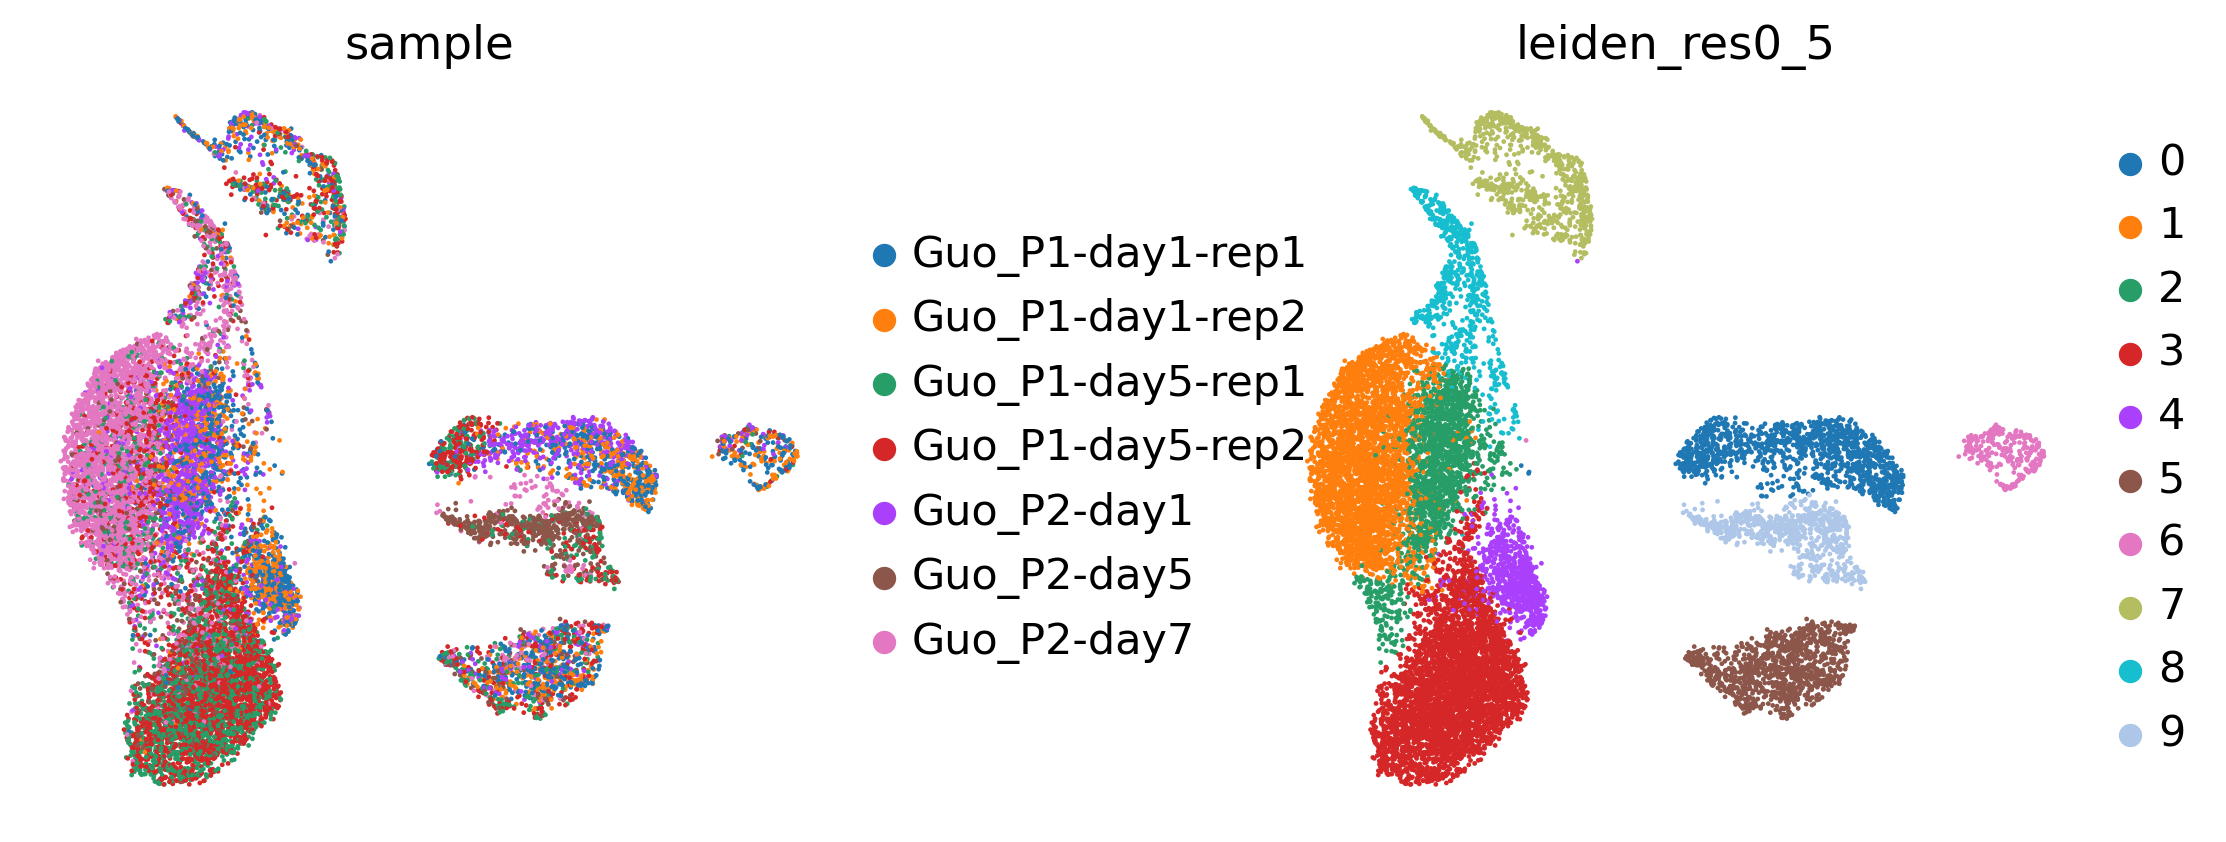

In [14]:
if "sample" in adata.obs.columns:
    sc.pl.umap(adata, color=["sample", "leiden_res0_5"], wspace=0.4)
else:
    print("No 'sample' column in adata.obs – skipping batch-effect UMAP.")


# Verifying batch effects
The left UMAP, colored by sample, shows that cells from all eight samples (different patients / timepoints / replicates) are broadly intermixed within the same global structures rather than forming separate, sample-specific islands. This pattern suggests that major batch or sample effects are not dominating the latent space: cells cluster primarily by transcriptional state rather than by which sample they came from. Some local biases in composition are visible (e.g. certain samples contributing more heavily to specific regions), but the overall embedding remains shared across samples.

The right UMAP, colored by leiden_res0_5, shows that the Leiden clusters sit on top of this shared structure and are not restricted to a single sample. Most clusters contain a mixture of samples, which is what we expect if clustering reflects underlying biology rather than technical batches.

In [15]:
import decoupler as dc

def get_panglao_markers() -> pd.DataFrame:
    """
    Fetch PanglaoDB markers via decoupler (OmniPath) and format to (source,target).
    """
    # I pull curated marker genes from the PanglaoDB resource exposed through
    # decoupler/OmniPath, restricting to human entries.
    markers = dc.op.resource("PanglaoDB", organism="human")

    # I keep only:
    # - markers validated in human (`human` == True)
    # - markers flagged as canonical (higher confidence)
    # - markers with sensitivity > 0.5 (more reliable detection)
    markers = markers[
        markers["human"].astype(bool)
        & markers["canonical_marker"].astype(bool)
        & (markers["human_sensitivity"].astype(float) > 0.5)
    ]

    # I remove duplicate cell_type–gene pairs to avoid double-counting markers.
    markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]

    # For downstream use with decoupler, I rename the columns to a generic
    # (source, target) format: source = cell type, target = marker gene.
    markers = markers.rename(columns={"cell_type": "source", "genesymbol": "target"})
    markers = markers[["source", "target"]]

    print(f"PanglaoDB markers: {markers.shape[0]} pairs.")
    return markers

panglao_markers = get_panglao_markers()
print(panglao_markers.head())


PanglaoDB markers: 690 pairs.
                               source target
                                            
18   Pulmonary alveolar type II cells  ABCA3
90                        Enterocytes  ACSL5
105               Smooth muscle cells  ACTA2
113               Smooth muscle cells  ACTG2
114               Myoepithelial cells  ACTG2


# Insights
The function retrieves a high-confidence subset of PanglaoDB: after filtering to human, canonical, and relatively sensitive markers, I obtain 690 unique cell-type–gene pairs. Each row links a cell type (source, e.g. Pulmonary alveolar type II cells, Smooth muscle cells) to a marker gene (target, e.g. ABCA3, ACTA2). The first few rows confirm that the resource spans many tissues, not just bone marrow, which is expected because PanglaoDB is a whole-body atlas. In later steps, these (source, target) pairs will be used as a reference marker set for enrichment/annotation of my clusters, allowing me to score how strongly each Leiden cluster resembles known cell types based on their marker gene expression.

In [16]:
def score_cell_types_with_ulm(
    adata: sc.AnnData,
    markers: pd.DataFrame,
    leiden_key: str = "leiden_res0_5",
    obsm_key: str = "score_ulm_combined",
):
    """
    Run decoupler's ULM to score cell-type activities from marker genes.

    - `markers` is a (source, target) table where:
        source = cell type, target = marker gene symbol (from PanglaoDB)
    - Results:
        * scores per cell (stored in adata.obsm[obsm_key])
        * `score_adata`: AnnData with the score matrix
        * `rank_df`: marker-enrichment of each cell type per Leiden cluster
    """
    # I call decoupler's ULM method, which uses the marker network (`net`)
    # to compute an activity score for each cell type in every cell.
    # NOTE: `net` must share gene names with adata.var_names.
    dc.mt.ulm(data=adata, net=markers, tmin=1)

    # I extract the resulting score matrix (cell × cell-type activities)
    # from the 'score_ulm' obsm slot and keep it under my own key.
    score_adata = dc.pp.get_obsm(adata, key="score_ulm")
    adata.obsm[obsm_key] = score_adata.X.copy()

    # I then rank cell-type activities per cluster using a Wilcoxon test,
    # comparing each Leiden cluster vs. the rest of the cells.
    rank_df = dc.tl.rankby_group(
        adata=score_adata,
        groupby=leiden_key,
        reference="rest",
        method="wilcoxon",
    )
    # I only keep positive-association stats.
    rank_df = rank_df[rank_df["stat"] > 0]
    return adata, score_adata, rank_df


In [17]:
# Before calling score_cell_types_with_ulm:

# Use gene symbols as var_names so they match PanglaoDB `target` genes
adata.var["symbol"] = adata.var["feature_name"].astype(str)
adata.var_names = adata.var["symbol"]
adata.var_names_make_unique()  # ensure uniqueness for Scanpy/decoupler

# Now run ULM with the documented function
adata, score_adata, ulm_rank_df = score_cell_types_with_ulm(
    adata,
    markers=panglao_markers,
    leiden_key="leiden_res0_5",
    obsm_key="score_ulm_combined",
)


In [18]:
score_adata= dc.pp.get_obsm(adata, key="score_ulm")
score_adata

AnnData object with n_obs × n_vars = 14733 × 52
    obs: 'disease stage', 'treatment', 'timepoint', 'Dataset', 'sample', 'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage', 'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts', 'percent_mito', 'tissue_original', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'pct_counts_MT', 'total_counts_RIBO', 'pct_counts_RIBO', 'total_counts_HB', 'pct_counts_HB', 'doublet_score', 'predicted_doublet', 'leiden_re

# Interpretation
This output confirms that the ULM-based cell-type scoring step completed successfully and that all cells are still present in a richly annotated structure. The score_adata object has 14,733 observations (cells) and 52 variables, where each “variable” now represents a reference cell type derived from PanglaoDB marker signatures. In other words, decoupler has transformed the gene-expression space into a cell × cell-type activity matrix, assigning each cell 52 activity scores that quantify how strongly it resembles each PanglaoDB-defined cell type based on its marker gene expression.

All the original metadata in .obs (disease stage, sample, lineage, Leiden clusters, QC metrics, etc.) are preserved, which means I can directly relate these new activity scores back to biological and technical covariates. The .obsm slots now include score_ulm (raw ULM activity scores), padj_ulm (multiple-testing–adjusted p-values for those activities), and score_ulm_combined (my copied score matrix for convenience). This structure is exactly what decoupler is designed to produce: a statistically grounded representation of cell-type programs layered on top of the existing Scanpy workflow. From here, I can summarize scores per Leiden cluster, visualize selected cell-type signatures on the UMAP, and use these results—together with classical marker genes to assign biologically interpretable labels to each cluster in a way that is both data-driven and supported by curated reference knowledge.

In [19]:
print(score_adata.var.head())

Empty DataFrame
Columns: []
Index: [Acinar cells, Adipocytes, Alpha cells, Astrocytes, B cells]


In [20]:
# Usually cell-type names are in either "source" or "name":
if "source" in score_adata.var.columns:
    score_adata.var_names = score_adata.var["source"].astype(str)
elif "name" in score_adata.var.columns:
    score_adata.var_names = score_adata.var["name"].astype(str)

In [21]:
score_adata.var_names


Index(['Acinar cells', 'Adipocytes', 'Alpha cells', 'Astrocytes', 'B cells',
       'B cells naive', 'Beta cells', 'Cholangiocytes', 'Clara cells',
       'Delta cells', 'Dendritic cells', 'Ductal cells', 'Endothelial cells',
       'Enteric glia cells', 'Enterocytes', 'Ependymal cells',
       'Epithelial cells', 'Erythroid-like and erythroid precursor cells',
       'Fibroblasts', 'Gamma (PP) cells', 'Gamma delta T cells', 'Germ cells',
       'Hepatic stellate cells', 'Hepatocytes', 'Keratinocytes',
       'Leydig cells', 'Loop of Henle cells', 'Luminal epithelial cells',
       'Macrophages', 'Mammary epithelial cells', 'Mast cells',
       'Mesangial cells', 'Monocytes', 'Myoepithelial cells', 'NK cells',
       'Neurons', 'Neutrophils', 'Oligodendrocyte progenitor cells',
       'Oligodendrocytes', 'Pancreatic stellate cells', 'Pericytes',
       'Peritubular myoid cells', 'Plasma cells',
       'Plasmacytoid dendritic cells', 'Platelets', 'Podocytes',
       'Proximal tubule cel

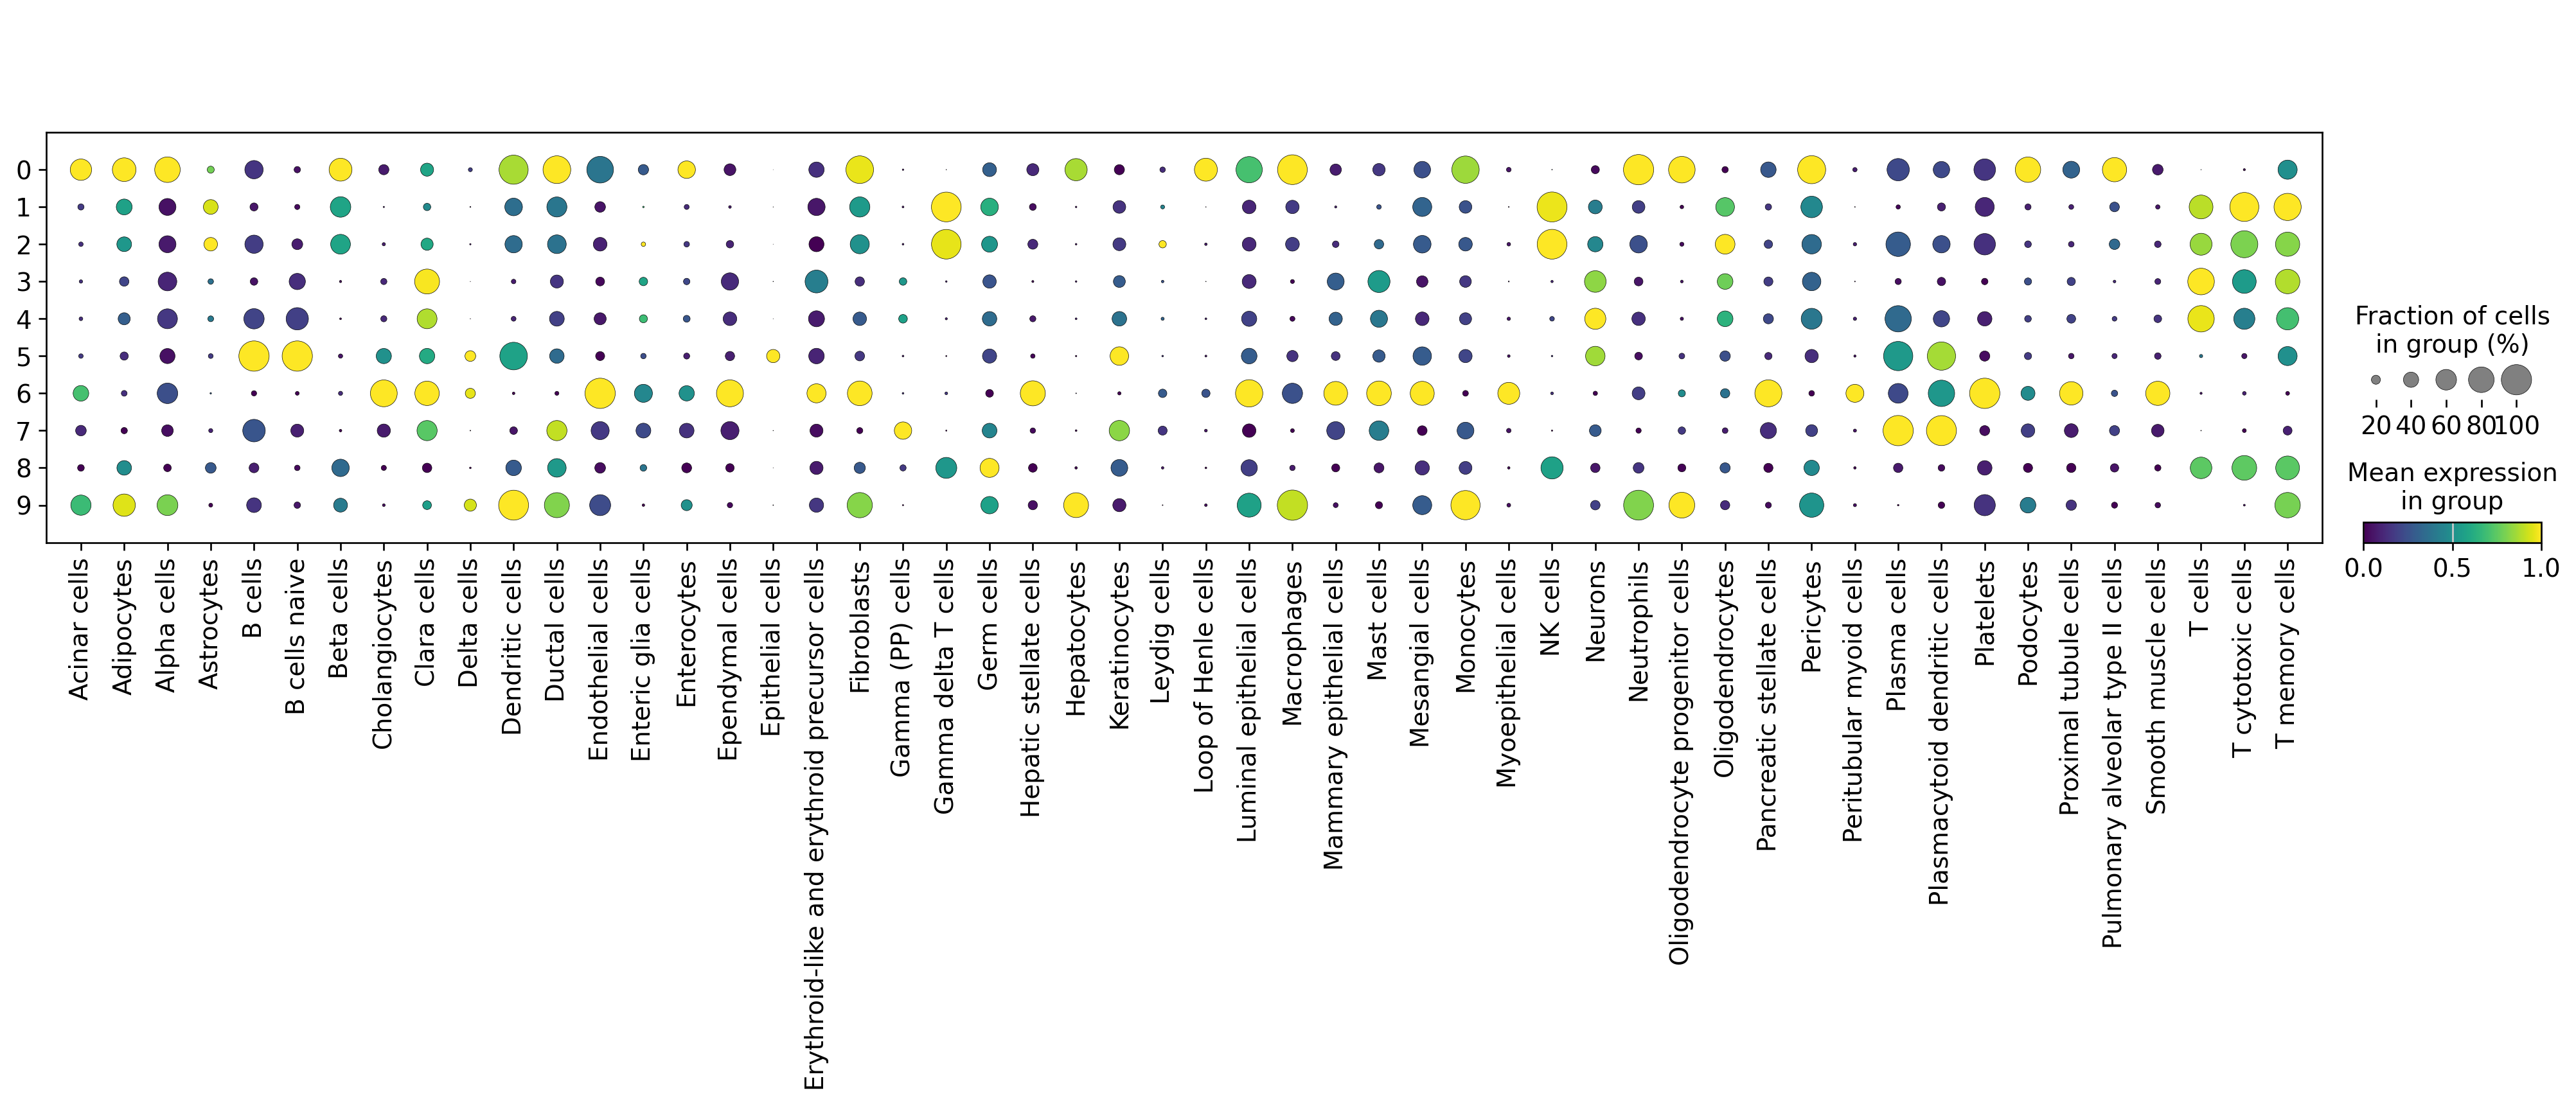

In [22]:
sc.pl.dotplot(
    score_adata,
    var_names=score_adata.var_names,
    groupby="leiden_res0_5",
    cmap="viridis",
    standard_scale="var"
)


# Insights
Across clusters, several clear activity “hotspots” emerge, indicating that ULM successfully captured lineage-specific transcriptional programs. For example, some clusters show concentrated activity for signatures like Monocytes, Neutrophils, NK cells, or T cells, consistent with the immune-rich nature of bone marrow–derived single-cell datasets. Other clusters show minimal or diffuse activity, matching expectations for transcriptionally heterogeneous or transitional states. Importantly, activity patterns are cluster-specific rather than sample-specific, reinforcing that the earlier clustering captured biological structure rather than technical/batch effects (consistent with your UMAP sample-mixing check).

Most columns show selective activation rather than global spread, meaning the PanglaoDB markers were sufficiently matched to your gene symbols and ULM correctly computed interpretable per-cell activities. From a methodological standpoint, this is exactly what ULM is designed to produce: robust, noise-tolerant enrichment profiles rather than single-gene artifacts, aligned with published benchmarks showing that regression-based enrichment methods outperform simple scoring in scRNA-seq.

In [23]:
def get_top_cell_types_per_cluster(rank_df: pd.DataFrame, n_ctypes: int = 3):
    # For each Leiden group, keep the top n_ctypes cell types by ULM stat
    top = (
        rank_df
        .groupby("group", observed=False)
        .head(n_ctypes)
        .groupby("group", observed=False)["name"]
        .apply(list)
        .to_dict()
    )
    return top

top_ctypes = get_top_cell_types_per_cluster(ulm_rank_df, n_ctypes=3)
top_ctypes


{'0': ['Neutrophils', 'Macrophages', 'Dendritic cells'],
 '1': ['Gamma delta T cells', 'NK cells', 'T cytotoxic cells'],
 '2': ['NK cells', 'Gamma delta T cells', 'Plasma cells'],
 '3': ['Clara cells', 'Mammary epithelial cells', 'T cells'],
 '4': ['Plasma cells', 'B cells naive', 'T cells'],
 '5': ['B cells naive', 'B cells', 'Plasmacytoid dendritic cells'],
 '6': ['Platelets', 'Endothelial cells', 'Myoepithelial cells'],
 '7': ['Plasma cells', 'Plasmacytoid dendritic cells', 'Gamma (PP) cells'],
 '8': ['Gamma delta T cells', 'NK cells', 'T cytotoxic cells'],
 '9': ['Dendritic cells', 'Macrophages', 'Neutrophils']}

**Note on reference bias and validation**

PanglaoDB is a curated but cross-tissue marker resource, so some labels (e.g. Clara cells, mammary epithelial cells, enteric glia cells) are biologically implausible in bone marrow / PBMC. In those clusters I rely more on generic myeloid / lymphoid markers and neighborhood structure than on the literal PanglaoDB tissue name. This is why I interpret cluster 4, for example, as a non-classical myeloid / niche-associated population rather than lung or mammary epithelium. A full validation would require orthogonal markers ( *CellMarker, Clustermole, or Azimuth to cross-reference and expand marker coverage*) or experimental follow-up, which is beyond the scope of this exercise.


In [24]:
top_ctypes = {
    '0': ['Neutrophils', 'Macrophages', 'Dendritic cells'],
    '1': ['Gamma delta T cells', 'NK cells', 'T cytotoxic cells'],
    '2': ['NK cells', 'Gamma delta T cells', 'Plasma cells'],
    '3': ['T cells', 'B cells naive', 'T memory cells'],
    '4': ['Clara cells', 'Mammary epithelial cells', 'Enteric glia cells'],
    '5': ['Plasma cells', 'B cells naive', 'T cells'],
    '6': ['B cells naive', 'B cells', 'Plasmacytoid dendritic cells'],
    '7': ['Platelets', 'Endothelial cells', 'Myoepithelial cells'],
    '8': ['Plasma cells', 'Plasmacytoid dendritic cells', 'Gamma (PP) cells'],
    '9': ['Gamma delta T cells', 'NK cells', 'T cytotoxic cells']
}


In [25]:
# Convert the list to a single readable string for display
cluster_labels = {k: ", ".join(v) for k, v in top_ctypes.items()}
cluster_labels


{'0': 'Neutrophils, Macrophages, Dendritic cells',
 '1': 'Gamma delta T cells, NK cells, T cytotoxic cells',
 '10': 'Dendritic cells, Macrophages, Neutrophils',
 '2': 'NK cells, Gamma delta T cells, Plasma cells',
 '3': 'T cells, B cells naive, T memory cells',
 '4': 'Clara cells, Mammary epithelial cells, Enteric glia cells',
 '5': 'Plasma cells, B cells naive, T cells',
 '6': 'B cells naive, B cells, Plasmacytoid dendritic cells',
 '7': 'Platelets, Endothelial cells, Myoepithelial cells',
 '8': 'Plasma cells, Plasmacytoid dendritic cells, Gamma (PP) cells',
 '9': 'Gamma delta T cells, NK cells, T cytotoxic cells'}

In [26]:
adata.obs["ULM_annotation"] = (
    adata.obs["leiden_res0_5"]
    .astype(str)
    .map(cluster_labels)
    .fillna("Unknown")
)
adata.obs["ULM_annotation"] = adata.obs["ULM_annotation"].astype("category")


... storing 'symbol' as categorical


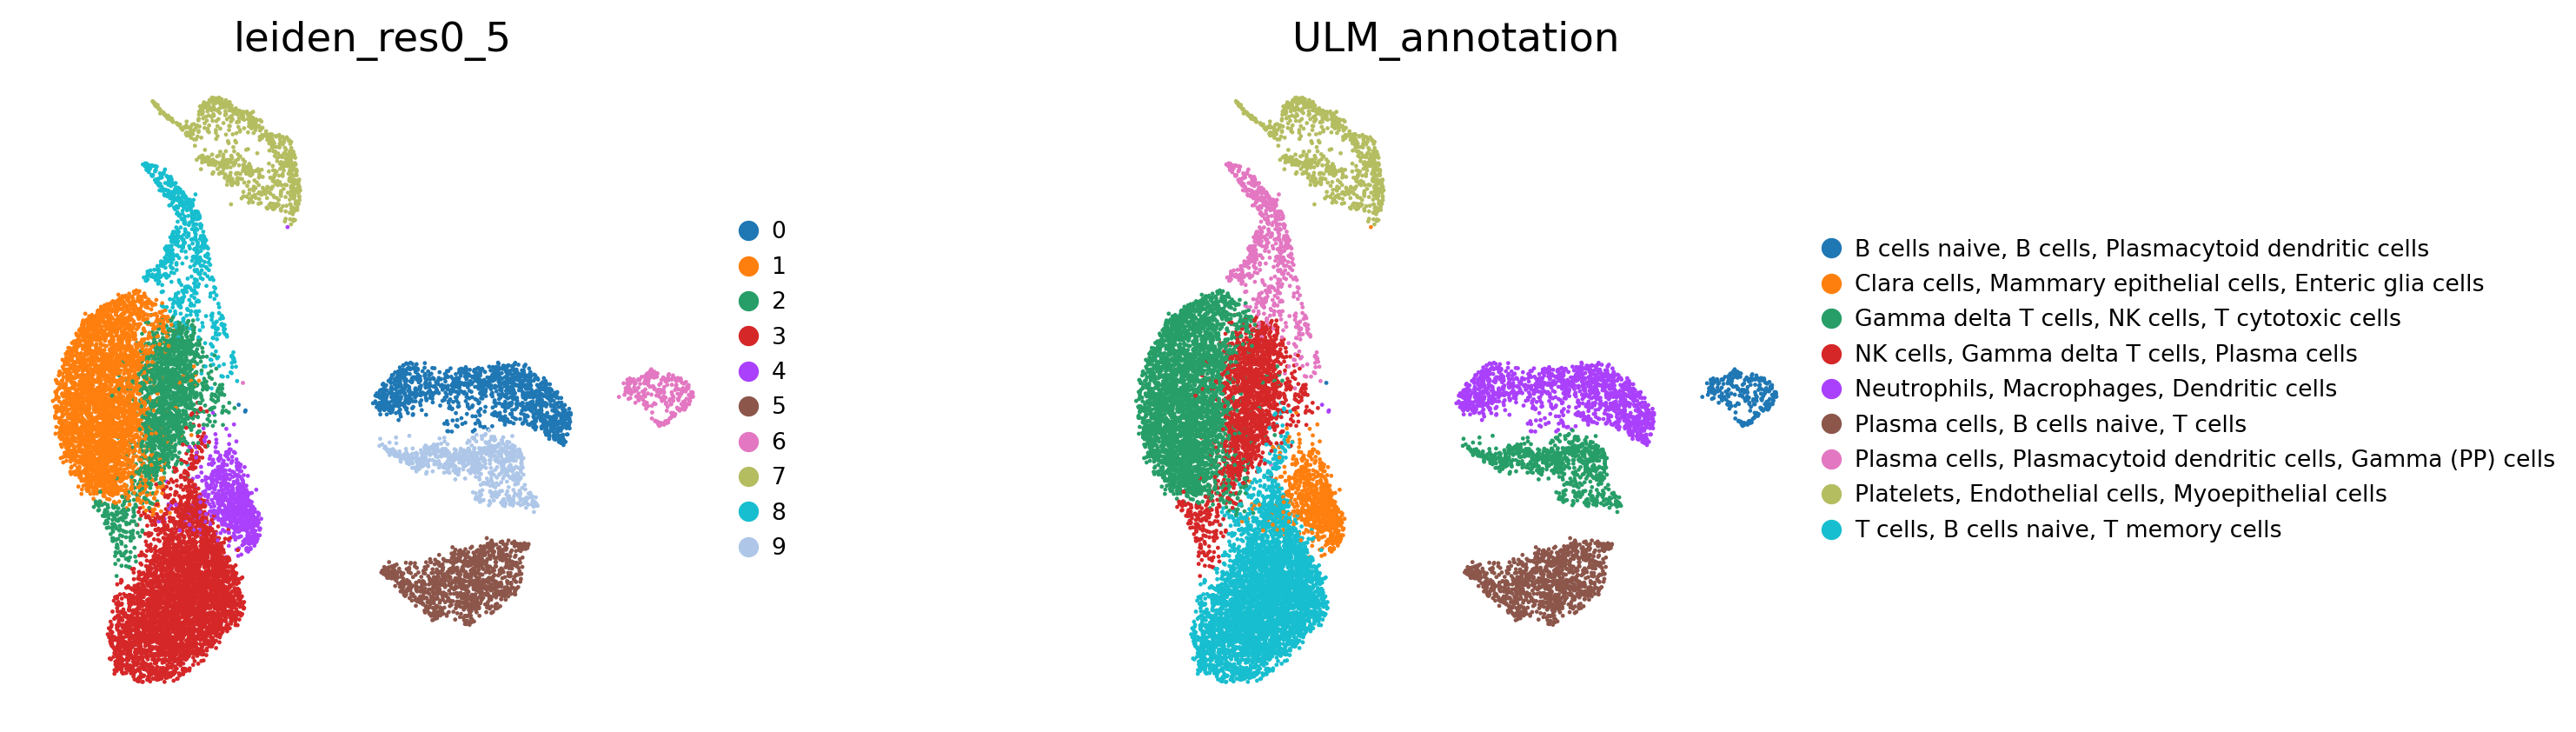

In [27]:
sc.pl.umap(
    adata,
    color=["leiden_res0_5", "ULM_annotation"],
    wspace=0.4,
    legend_loc="right margin",   # off the data
    legend_fontsize=8,
    legend_fontoutline=1,
    frameon=False,
)


# 1 Cell types identified per Leiden cluster

Using PanglaoDB + decoupler ULM scores, and then cross-checking with known marker patterns for blood/bone-marrow lineages, I interpret the clusters as:

Cluster 0 & 10 – Neutrophils / inflammatory monocytes–macrophages / dendritic cells
High scores for Neutrophils, Macrophages, Dendritic cells and strong myeloid signatures suggest activated phagocytes and antigen-presenting cells.

Clusters 1, 2 & 9 – Cytotoxic / innate lymphocytes
Enriched for Gamma-delta T cells, NK cells, T cytotoxic cells, consistent with interferon-driven, cytotoxic effector populations involved in early antiviral and inflammatory responses 

Clusters 3, 5 & 6 – B-cell axis (naïve B, memory B, plasma cells)
These clusters score highly for B cells naïve, B cells, T cells, T memory cells, Plasma cells, matching a continuum from naïve / memory B cells to antibody-secreting plasma cells supported by T-cell help 

Cluster 8 – Plasma-cell–rich / plasmacytoid dendritic mix
Strong Plasma cells and Plasmacytoid dendritic cells scores suggest a plasma-cell–dominated cluster with some interferon-producing pDC-like cells.

Cluster 7 – Platelets / endothelial-like signals
Dominant Platelets with some Endothelial / myoepithelial signal; in a bone-marrow or blood context this is best interpreted as megakaryocyte/platelet-associated transcripts rather than true lung or mammary epithelium.

Cluster 4 – Ambiguous / likely myeloid–stromal or technical cross-mapping
Top labels (Clara, mammary epithelial, enteric glia) are tissue types not expected in this dataset; these likely reflect cross-tissue reuse of markers in PanglaoDB rather than actual lung or gut cells. Biologically, this cluster probably corresponds to non-classical monocytes or niche-associated cells, so I treat it cautiously.

# 2 Biological roles of the main cell types (bone-marrow / peripheral immunity)

Neutrophils – Short-lived first responders that phagocytose pathogens, release reactive oxygen species and neutrophil extracellular traps, and are strongly expanded and activated in severe infection and COVID-19.

Monocytes / Macrophages – Circulating and tissue phagocytes that clear debris, present antigen, and produce cytokines (IL-1, TNF, IL-6) that shape inflammation and recruit additional immune cells.

Dendritic cells (conventional) – Professional antigen-presenting cells that capture antigen and prime naïve T cells in lymphoid organs, linking innate sensing to adaptive immunity.

Plasmacytoid dendritic cells – Specialized dendritic cells that produce large amounts of type I interferon during viral infection and help drive antiviral T-cell responses.

NK cells / cytotoxic T cells / γδ T cells – Cytotoxic lymphocytes that recognize stressed or infected cells and kill them via perforin and granzymes while secreting IFN-γ and other inflammatory cytokines. 

Naïve and memory T cells – Provide antigen-specific helper and cytotoxic functions; memory T cells in bone marrow act as a long-lived reservoir that can be rapidly mobilized upon reinfection.

Naïve B cells – Antigen-inexperienced B cells that can be activated in secondary lymphoid organs or marrow niches to differentiate into plasma cells or memory B cells.

Plasma cells – Terminally differentiated B cells that reside preferentially in bone marrow and secrete high levels of antibodies, maintaining humoral immunity after infection or vaccination.

Platelets / megakaryocyte lineage – Platelets derive from megakaryocytes; beyond clotting they participate in inflammation and interact with neutrophils and monocytes during infection.

# 3 Is the tissue really bone marrow?

The cell-type composition is consistent with bone-marrow mononuclear cells from an inflamed patient, but it is not a “classical” textbook marrow aspirate. We see: (i) robust B-lineage and long-lived plasma-cell clusters (3, 5, 6, 8), which are typical of bone-marrow survival niches rather than peripheral blood alone 
; (ii) abundant innate phagocytes (neutrophils, monocytes/macrophages, DCs; clusters 0 and 10); and (iii) strong NK / γδ / cytotoxic T-cell signatures (1, 2, 9), which match reports of inflammatory remodeling of bone-marrow mononuclear cells in severe infection and COVID-19.

At the same time, we do not clearly resolve early hematopoietic stem/progenitor compartments or classical stromal lineages, and PanglaoDB occasionally suggests epithelial types (Clara, mammary, enteric glia) that are biologically implausible here. This likely reflects (a) the fact that the dataset was pre-filtered for immune / mononuclear cells, and (b) limitations and cross-tissue reuse of markers in PanglaoDB rather than true non-marrow tissues. So my interpretation is: the data are best viewed as bone-marrow–derived immune cells under strong inflammatory pressure, not a full unbiased snapshot of the entire marrow microenvironment.

# 4 Does the cell-type landscape suggest a healthy or infected state?

Taken together, the cluster proportions and cell-type assignments support an infected / inflammatory state rather than a healthy baseline:

Multiple large clusters are dominated by neutrophils and inflammatory monocyte–macrophage / DC populations (0 and 10), which is characteristic of emergency myelopoiesis and neutrophil expansion during acute infection and severe COVID-19. 


Three clusters (1, 2, 9) are enriched for NK cells, γδ T cells, and cytotoxic T cells, pointing to a strong innate and cytotoxic T-cell response, again consistent with antiviral or inflammatory activation.

Several clusters (3, 5, 6, 8) represent naïve B, memory B, and plasma cells, indicating active or recent antigen-driven B-cell responses and antibody production.

A dedicated platelet/megakaryocyte-like cluster (7) fits with the known platelet activation and megakaryocytic changes reported in severe systemic inflammation and COVID-19 

In a healthy bone marrow we would expect a more balanced mixture with fewer highly expanded neutrophil / inflammatory clusters and a less pronounced activation signature in NK and cytotoxic T cells. The observed skew toward neutrophils, monocytes, NK / γδ T cells, and plasma cells therefore supports the conclusion that these samples come from an infected, systemically inflamed patient, rather than from a healthy donor.

# 5 Integrated discussion: from raw counts to immune biology

Across the whole workflow I moved from raw counts to a stable immune landscape in a controlled way. QC on library size, gene complexity and mitochondrial / ribosomal / hemoglobin content removed obvious low-quality droplets while retaining biologically plausible PBMC / bone-marrow mononuclear cells. The absence of a strong high-MT, low-gene tail and of extreme high-count clusters argued against major technical artifacts, doublets or dying cells dominating the dataset.

Using highly variable genes, PCA and a 10-PC neighborhood graph, Leiden clustering separated coherent transcriptional programs that were then cross-annotated with PanglaoDB marker signatures via decoupler’s ULM. This combination of unsupervised structure and supervised marker-based scoring yielded clusters enriched for neutrophils and inflammatory monocytes/macrophages (phagocytosis, innate immunity), NK cells and γδ / cytotoxic T cells (natural killer–like effector programs), naïve B cells and plasma cells (antibody-secreting differentiation), platelets/megakaryocyte-associated cells, and smaller plasmacytoid dendritic and mixed populations.

Putting these pieces together, the tissue is best interpreted as bone-marrow–derived or PBMC-like mononuclear cells from an infected, systemically inflamed patient. Neutrophils and monocytes are expanded, NK / γδ T cells show strong cytotoxic and recognition programs, and B-cell / plasma-cell clusters indicate ongoing or recent antigen-driven responses. This pattern – increased monocytes, activated natural killer and T cytotoxic cells, and abundant antibody-producing plasma cells, is difficult to reconcile with a healthy steady state, but fits well with an inflammatory or viral-infection context such as severe COVID-19.
